Siglent Technologies,SDG1032X,SDG1XCBX5R2294,1.01.01.33R3




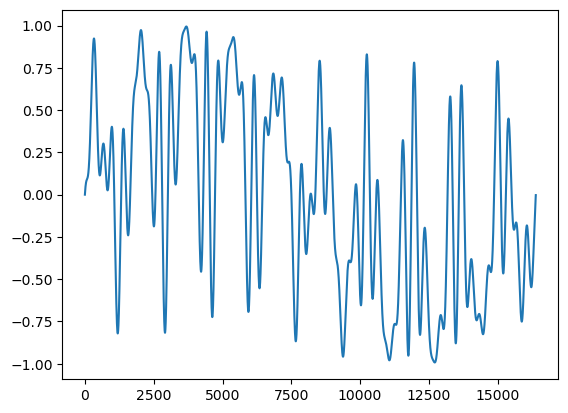

In [2]:
# Export a waveform to the Siglent SDG1032X arbitrary waveform generator using SCPI.
# In this case a left 1kHz, right 10kHz FM stereo signal is created.
#
# Note that the SDG1032X has a bug, which regards any \x0a byte as a termination character and closes
# communication with the computer. This means that if a \x0a value is part of the waveform itself, 
# not the entire waveform is received by the SDG1032X. In many cases the SDG1032X will hang when an
# intermediate \x0a value is received. This bug can be circumvented by before sending the waveform
# to the SDG1032X, any \x0a values in the waveform are replaced by \x0b. This results in an error 
# of 100*1/32767=0.3% if the \x0a is low byte, 100*256/32767=0.8% if \x0a is in the high byte.
#
# see: https://www.eevblog.com/forum/testgear/siglent-sdg1032x-bug-in-user-defined-waveforms/msg4677745/#msg4677745
#
#
#
import socket
import time
import sys
import binascii
import matplotlib.pyplot as plt
import numpy as np

ip = '192.168.1.118'

def open_socket():
    try:
        s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        s.connect((ip, 5025))
        s.settimeout(0.5)
    except socket.error:
        print('Failed to connect')
        sys.exit()

    return s

def close_socket(s):
    s.close()
    time.sleep(.300)

def send_command(s, cmd):
    try:
        s.sendall(cmd)
        time.sleep(1)
    except socket.error:
        print('Command failed')
        sys.exit()

    try:
        response = s.recv(4096)
    except socket.timeout:
        response = b''

    return response


# replaces all b'\n' values with a very similar value.
# b'\n' is treated as a termination character by the SDG1032X.
def waveform_data(signal):
    d = (signal*32767).astype(np.int16)
    return d.tobytes().replace(b'\n',b'\x0b')


SAMPLES = 16384

# time axis
t = np.linspace(0,1,SAMPLES,endpoint=False)


f1 = 1
f2 = 10
f19 = 19
f38 = 38

s1 = np.sin(f1*2*np.pi*t)
s2 = np.sin(f2*2*np.pi*t)
s19 = np.sin(f19*2*np.pi*t)
s38 = np.sin(f38*2*np.pi*t)

# FM signal
ratio = .9
left = s1
right = s2
tone = s19
mono = (left + right) / 2
stereo = s38 * (left - right) / 2
signal = ratio * (mono + stereo) + (1 - ratio) * tone

s = open_socket()
qstr = send_command(s, b'*IDN?\n')
print(qstr.decode('utf-8'))

data = waveform_data(signal)

qstr = send_command(s, b"C1:WVDT WVNM,L1_R10,FREQ,1000.0,AMPL,1.0,OFST,0.0, PHASE,0.0,WAVEDATA," + data + b'\n')
print(qstr.decode('utf-8'))
close_socket(s)

plt.plot(signal)